In [1]:
# generic imports
import numpy as np
from matplotlib import pyplot as plt
import multiprocessing as mp
# orbitize imports
import orbitize
from orbitize import read_input, system, priors, sampler

In [2]:
# mutual incl formula

def mutualInc(Id, Ib, Omd, Omb, verb=False):
    cosD = (np.cos(Id)*np.cos(Ib))+(np.sin(Id)*np.sin(Ib)*np.cos(Omd-Omb))
    D = np.arccos(cosD)
    if verb is True:
        print('disk-binary mutual inclination is: '+str(D))
    return D

In [3]:
data_table = read_input.read_file('hd142-allast-orbitizelike.csv')

In [4]:
# number of secondary bodies in system
num_planets = 1

# total mass & error [msol]
system_mass = 2.25
mass_err = 0.5

# parallax & error[mas]
plx = 6.35606723729484
plx_err = 0.04714455423

sys = system.System(
    num_planets, data_table, system_mass,
    plx, mass_err=mass_err, plx_err=plx_err
)
lab = sys.param_idx

# enforcing coplanarity

In [5]:
# enforce coplanar disk
# i_disk from Perez 2015
Imu = 28.
Isigma = 0.5
# Omega_disk from Perez 2015 / Boehler 2017
Omu = 19.
Osigma = 1.

sys.sys_priors[lab['inc1']] = priors.GaussianPrior(Imu, Isigma)
sys.sys_priors[lab['pan1']] = priors.GaussianPrior(Omu, Osigma)

# print(sys.labels)
# print(sys.sys_priors)

In [ ]:
# number of temperatures & walkers for MCMC
num_temps = 20
num_walkers = 50

num_threads = mp.cpu_count() # or a different number if you prefer
mcmc_sampler = sampler.MCMC(sys, num_temps=num_temps, num_walkers=num_walkers, num_threads=num_threads)

# number of orbits
n_orbs = 1e6*num_walkers
burnin = 1e5
_ = mcmc_sampler.run_sampler(int(n_orbs), burn_steps=int(burnin), thin=5)

# save result as hdf5
hdf5_filename='coplanar_posterior_thin.hdf5'
import os
# To avoid weird behaviours, delete saved file if it already exists from a previous run of this notebook
if os.path.isfile(hdf5_filename):
    os.remove(hdf5_filename)
mcmc_sampler.results.save_results(hdf5_filename)

Starting Burn in


/home/wbalmer21/.local/lib/python3.8/site-packages/orbitize/priors.py:168: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/wbalmer21/.local/lib/python3.8/site-packages/orbitize/priors.py:168: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/wbalmer21/.local/lib/python3.8/site-packages/orbitize/priors.py:168: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/wbalmer21/.local/lib/python3.8/site-packages/orbitize/priors.py:168: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/wbalmer21/.local/lib/python3.8/site-packages/orbitize/priors.py:168: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/wbalmer21/.local/lib/python3.8/site-packages/orbitize/priors.py:168: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((e

In [8]:
coplanarResults = orbitize.results.Results()
coplanarResults.load_results('coplanar_posterior.hdf5') # load from file

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'number of orbits')

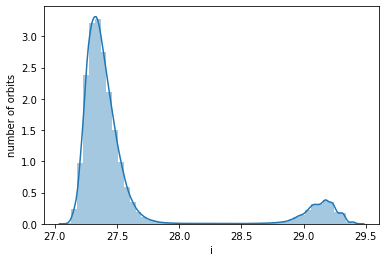

In [9]:
import seaborn as sb
accepted_incls = coplanarResults.post[:, lab['inc1']]
sb.distplot(accepted_incls)
plt.xlabel('i'); plt.ylabel('number of orbits')

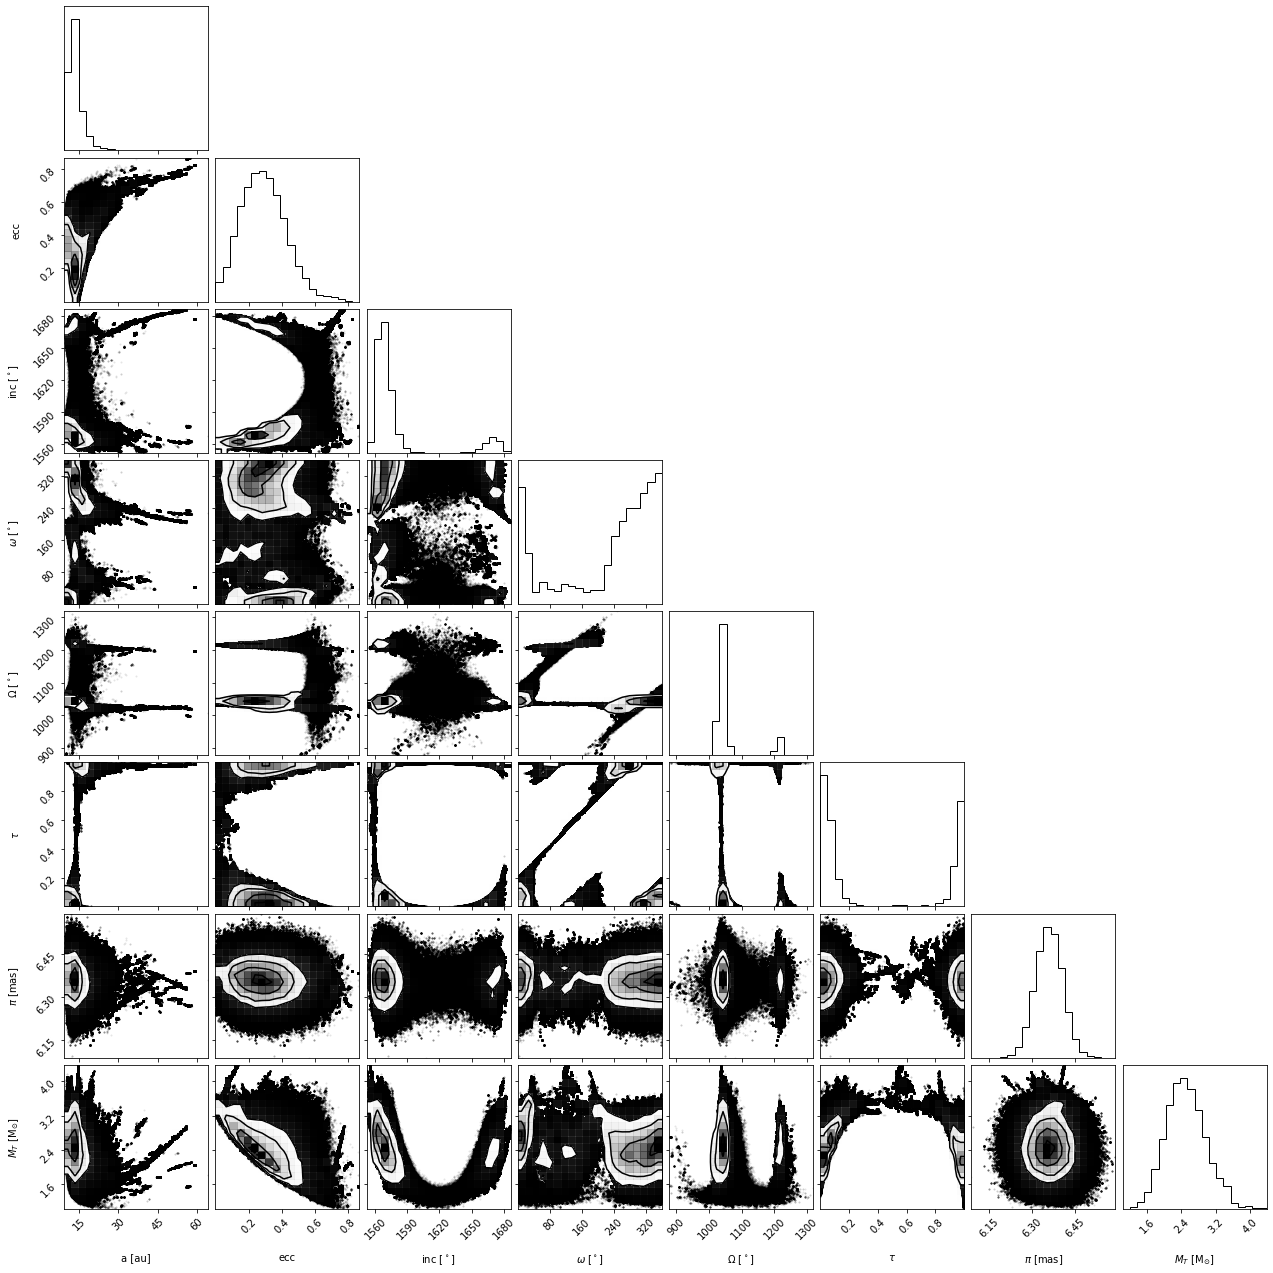

In [10]:
corner_plot_fig = coplanarResults.plot_corner()

In [17]:
import warnings
warnings.filterwarnings('ignore')

NACO [0, 1, 3]
VisAO [2, 4, 7, 8, 9, 16]
GPI [5]
SPHERE/IFS/IRDIS [6, 10, 11, 13, 14, 15]
SPHERE/ZIMPOL [12]


<Figure size 1008x432 with 0 Axes>

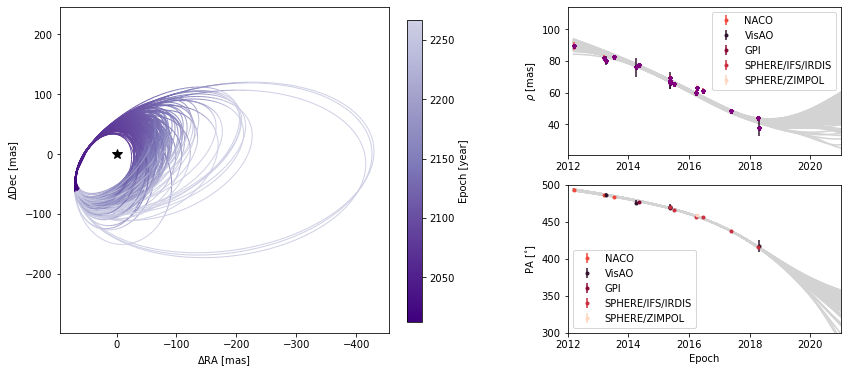

<Figure size 432x288 with 0 Axes>

In [20]:
from astropy.time import Time
import pandas as pd
epochs = sys.data_table['epoch']
epochs_yr = Time(epochs, format='mjd').decimalyear
# grab data from Driver object
data_tab = pd.read_csv('hd142-allast-full.csv')
data_tab['yr'] = epochs_yr
data_tab['pa'][data_tab['pa'] < 180] += 360
data_tab['ra'], data_tab['dec'] = orbitize.system.seppa2radec(data_tab['sep'], data_tab['pa'])
data_tab['ra_err'] = np.sqrt((data_tab['pa_err']/data_tab['pa'])**2 + (data_tab['sep_err']/data_tab['sep'])**2)*data_tab['ra']
data_tab['dec_err'] = np.sqrt((data_tab['pa_err']/data_tab['pa'])**2 + (data_tab['sep_err']/data_tab['sep'])**2)*data_tab['dec']

insts = []
for inst in data_tab['inst']:
    if inst not in insts:
        insts.append(inst)
instdict = {}
for inst in insts:
    inds = []
    for i in data_tab.index:
        if inst == data_tab['inst'].iloc[i]:
            inds.append(i)
    print(inst, inds)
    instdict[inst] = data_tab.iloc[inds]

orb_fig = mcmc_sampler.results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 200, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
#     data = sys.data_table,
    mod180=True
)
colors = ['#ef473a', '#30122d', '#870734', '#cb2d3e', '#ffd6bf']
ax_orb, ax_sep, ax_pa, ax_cbar  = orb_fig.axes
c = 0
for inst in insts:
    data_tab = instdict[inst]
    color = colors[c]
    c += 1
    # add data to sep panel
    ax_sep.errorbar(
        data_tab['yr'], data_tab['sep'], data_tab['sep_err'],
        color=color, 
        linestyle='', fmt='o', zorder=3, label=inst, markersize=3
    )

    # add data to PA panel
    ax_pa.errorbar(
        data_tab['yr'], data_tab['pa'], data_tab['pa_err'],
        color=color, 
        linestyle='', fmt='o', zorder=3, label=inst, markersize=3
    )

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_sep.legend()
ax_pa.legend()

# zoom in a bit
ax_sep.set_xlim(2012,2021)
ax_pa.set_xlim(2012,2021)
# ax_sep.set_ylim(113.5,118)
ax_pa.set_ylim(300,500)
plt.show()
plt.savefig('hd142527B_coplanar.png', transparent=True, dpi=150) # This is matplotlib.figure.Figure.savefig()

# multimodal priors work

In [ ]:
mu = [0.2,0.6]
sigma = [0.01, 0.01]

sys.sys_priors[lab['ecc1']] = priors.MultiGaussianPrior(mu, sigma)

# print(sys.labels)
# print(sys.sys_priors)
# print(vars(sys.sys_priors[lab['ecc1']]))

In [5]:
import scipy.stats as ss
# Set-up.
n = 10000
# Parameters of the mixture components
norm_params = np.array([mu, sigma]).T
n_components = norm_params.shape[0]
# Weight of each component, in this case all of them are 1/3
weights = np.ones(n_components, dtype=np.float64) / 2
# A stream of indices from which to choose the component
mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
# y is the mixture sample
y = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                   dtype=np.float64)

# Theoretical PDF plotting -- generate the x and y plotting positions
xs = np.linspace(y.min(), y.max(), 200)
ys = np.zeros_like(xs)

for (l, s), w in zip(norm_params, weights):
    ys += ss.norm.pdf(xs, loc=l, scale=s) * w

Starting Burn in

Burn in complete. Sampling posterior now.


c:\users\willi\amherst\thesis\code\orbitize\orbitize\priors.py:256: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
c:\users\willi\amherst\thesis\code\orbitize\orbitize\priors.py:365: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


c:\users\willi\amherst\thesis\code\orbitize\orbitize\kepler.py:87: RuntimeWarning: invalid value encountered in sqrt
  tanom = 2.*np.arctan(np.sqrt((1.0 + ecc)/(1.0 - ecc))*np.tan(0.5*eanom))
c:\programdata\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\users\willi\amherst\thesis\code\orbitize\orbitize\system.py:460: RuntimeWarning: invalid value encountered in remainder
  pa = np.degrees(np.arctan2(ra, dec)) % 360.
c:\users\willi\amherst\thesis\code\orbitize\orbitize\lnlike.py:51: RuntimeWarning: invalid value encountered in remainder
  residual[:, seppa_indices, 1] = (residual[:, seppa_indices, 1] + 180.) % 360. - 180.


c:\users\willi\amherst\thesis\code\orbitize\orbitize\kepler.py:270: RuntimeWarning: invalid value encountered in sqrt
  aux = np.sqrt(beta**2.0 + alpha**3.0)


100/100 steps completed
Run complete


Text(0, 0.5, 'number of orbits')

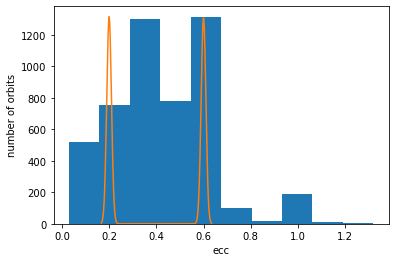

In [6]:
# number of temperatures & walkers for MCMC
num_temps = 3
num_walkers = 50

# number of steps to take
n_orbs = 10000

mcmc_sampler = sampler.MCMC(sys, num_temps, num_walkers)

# number of orbits to accept
n_orbs = 5000

_ = mcmc_sampler.run_sampler(n_orbs)

accepted_eccentricities = mcmc_sampler.results.post[:, lab['ecc1']]
y, x, _ = plt.hist(accepted_eccentricities)
plt.plot(xs, ys*(y.max()/ys.max()))
plt.xlabel('ecc'); plt.ylabel('number of orbits')
# plt.savefig('mixture_ex_eccen.png')

In [7]:
Id = 28 # incl of disk
Ib = 130 # incl of binary
Omd = -20 # PA / angle of asc node of disk
Omb = 120 # angle of asc node of binary
D = mutualInc(Id, Ib, Omd, Omb, verb=True)

disk-binary mutual inclination is: 1.155566661359039


In [22]:
# best estimates
ids = [180-28, 180-26.9] # perez2015, fukagawa 2013
iderrs = [0.5, 2.2]

omds = [180-19, 180-19] #fukagawa 2013, boehler 2017
omderrs = [2, 1]

In [9]:
# all estimates
ids = [20, 23, 28, 26.9, 27] # verhoeff 2011*, avenhaus 2014, perez 2015, fukagawa 2013, boehler 2017*
iderrs = [10, 9, 0.5, 2.2, 10]

omds = [-20, -2.5, -20, -19, -19] # verhoeff 2011*, avenhaus 2014, perez 2015*, fukagawa 2013, boehler 2017 
omderrs = [10, 2, 10, 2, 1]

#* (no error reported, assumed +/-10)

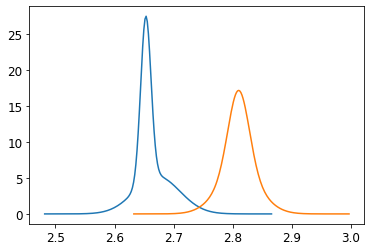

In [23]:
# post -> gives Ib, Omb
# draw samples from Id, Omd priors
# calc mutual incl
# append to post
# plot

# load in saved hdf5 result
hdf5_filename='thesis_posterior.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename) 

data = loaded_results.post

Id_mu = np.array(ids) 
Id_sigma = np.array(iderrs)/Id_mu

Id_mu = np.deg2rad(Id_mu)
Id_sigma = Id_sigma*Id_mu

Omd_mu = np.array(omds)
Omd_sigma = np.array(omderrs)/Omd_mu

Omd_mu = np.deg2rad(Omd_mu)
Omd_sigma = Omd_sigma*Omd_mu

diskdata = np.zeros((len(data[:, 2]), 5))
diskdata[:,0] = data[:, 2]
diskdata[:,1] = data[:, 4]
i = 2
for paramset in [[Id_mu, Id_sigma], [Omd_mu, Omd_sigma]]:
    # Set-up.
    n = len(data[:, 2])
    # Parameters of the mixture components
    norm_params = np.array(paramset).T
    n_components = norm_params.shape[0]
    # Weight of each component, in this case all of them are 1/3
    weights = np.ones(n_components, dtype=np.float64) / n_components
    # A stream of indices from which to choose the component
    mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
    # y is the mixture sample
    y = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                       dtype=np.float64)
    
    diskdata[:, i] = y
    i += 1
    # Theoretical PDF plotting -- generate the x and y plotting positions
    xs = np.linspace(y.min(), y.max(), 200)
    ys = np.zeros_like(xs)

    for (l, s), w in zip(norm_params, weights):
        ys += ss.norm.pdf(xs, loc=l, scale=s) * w
    plt.plot(xs, ys)

In [24]:
diskdata[:, 4] = mutualInc(diskdata[:,2], diskdata[:,0], diskdata[:,3], diskdata[:,1])
data2 = np.concatenate((data, diskdata), axis=1)
diskdatadeg = np.degrees(diskdata)

In [14]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import corner

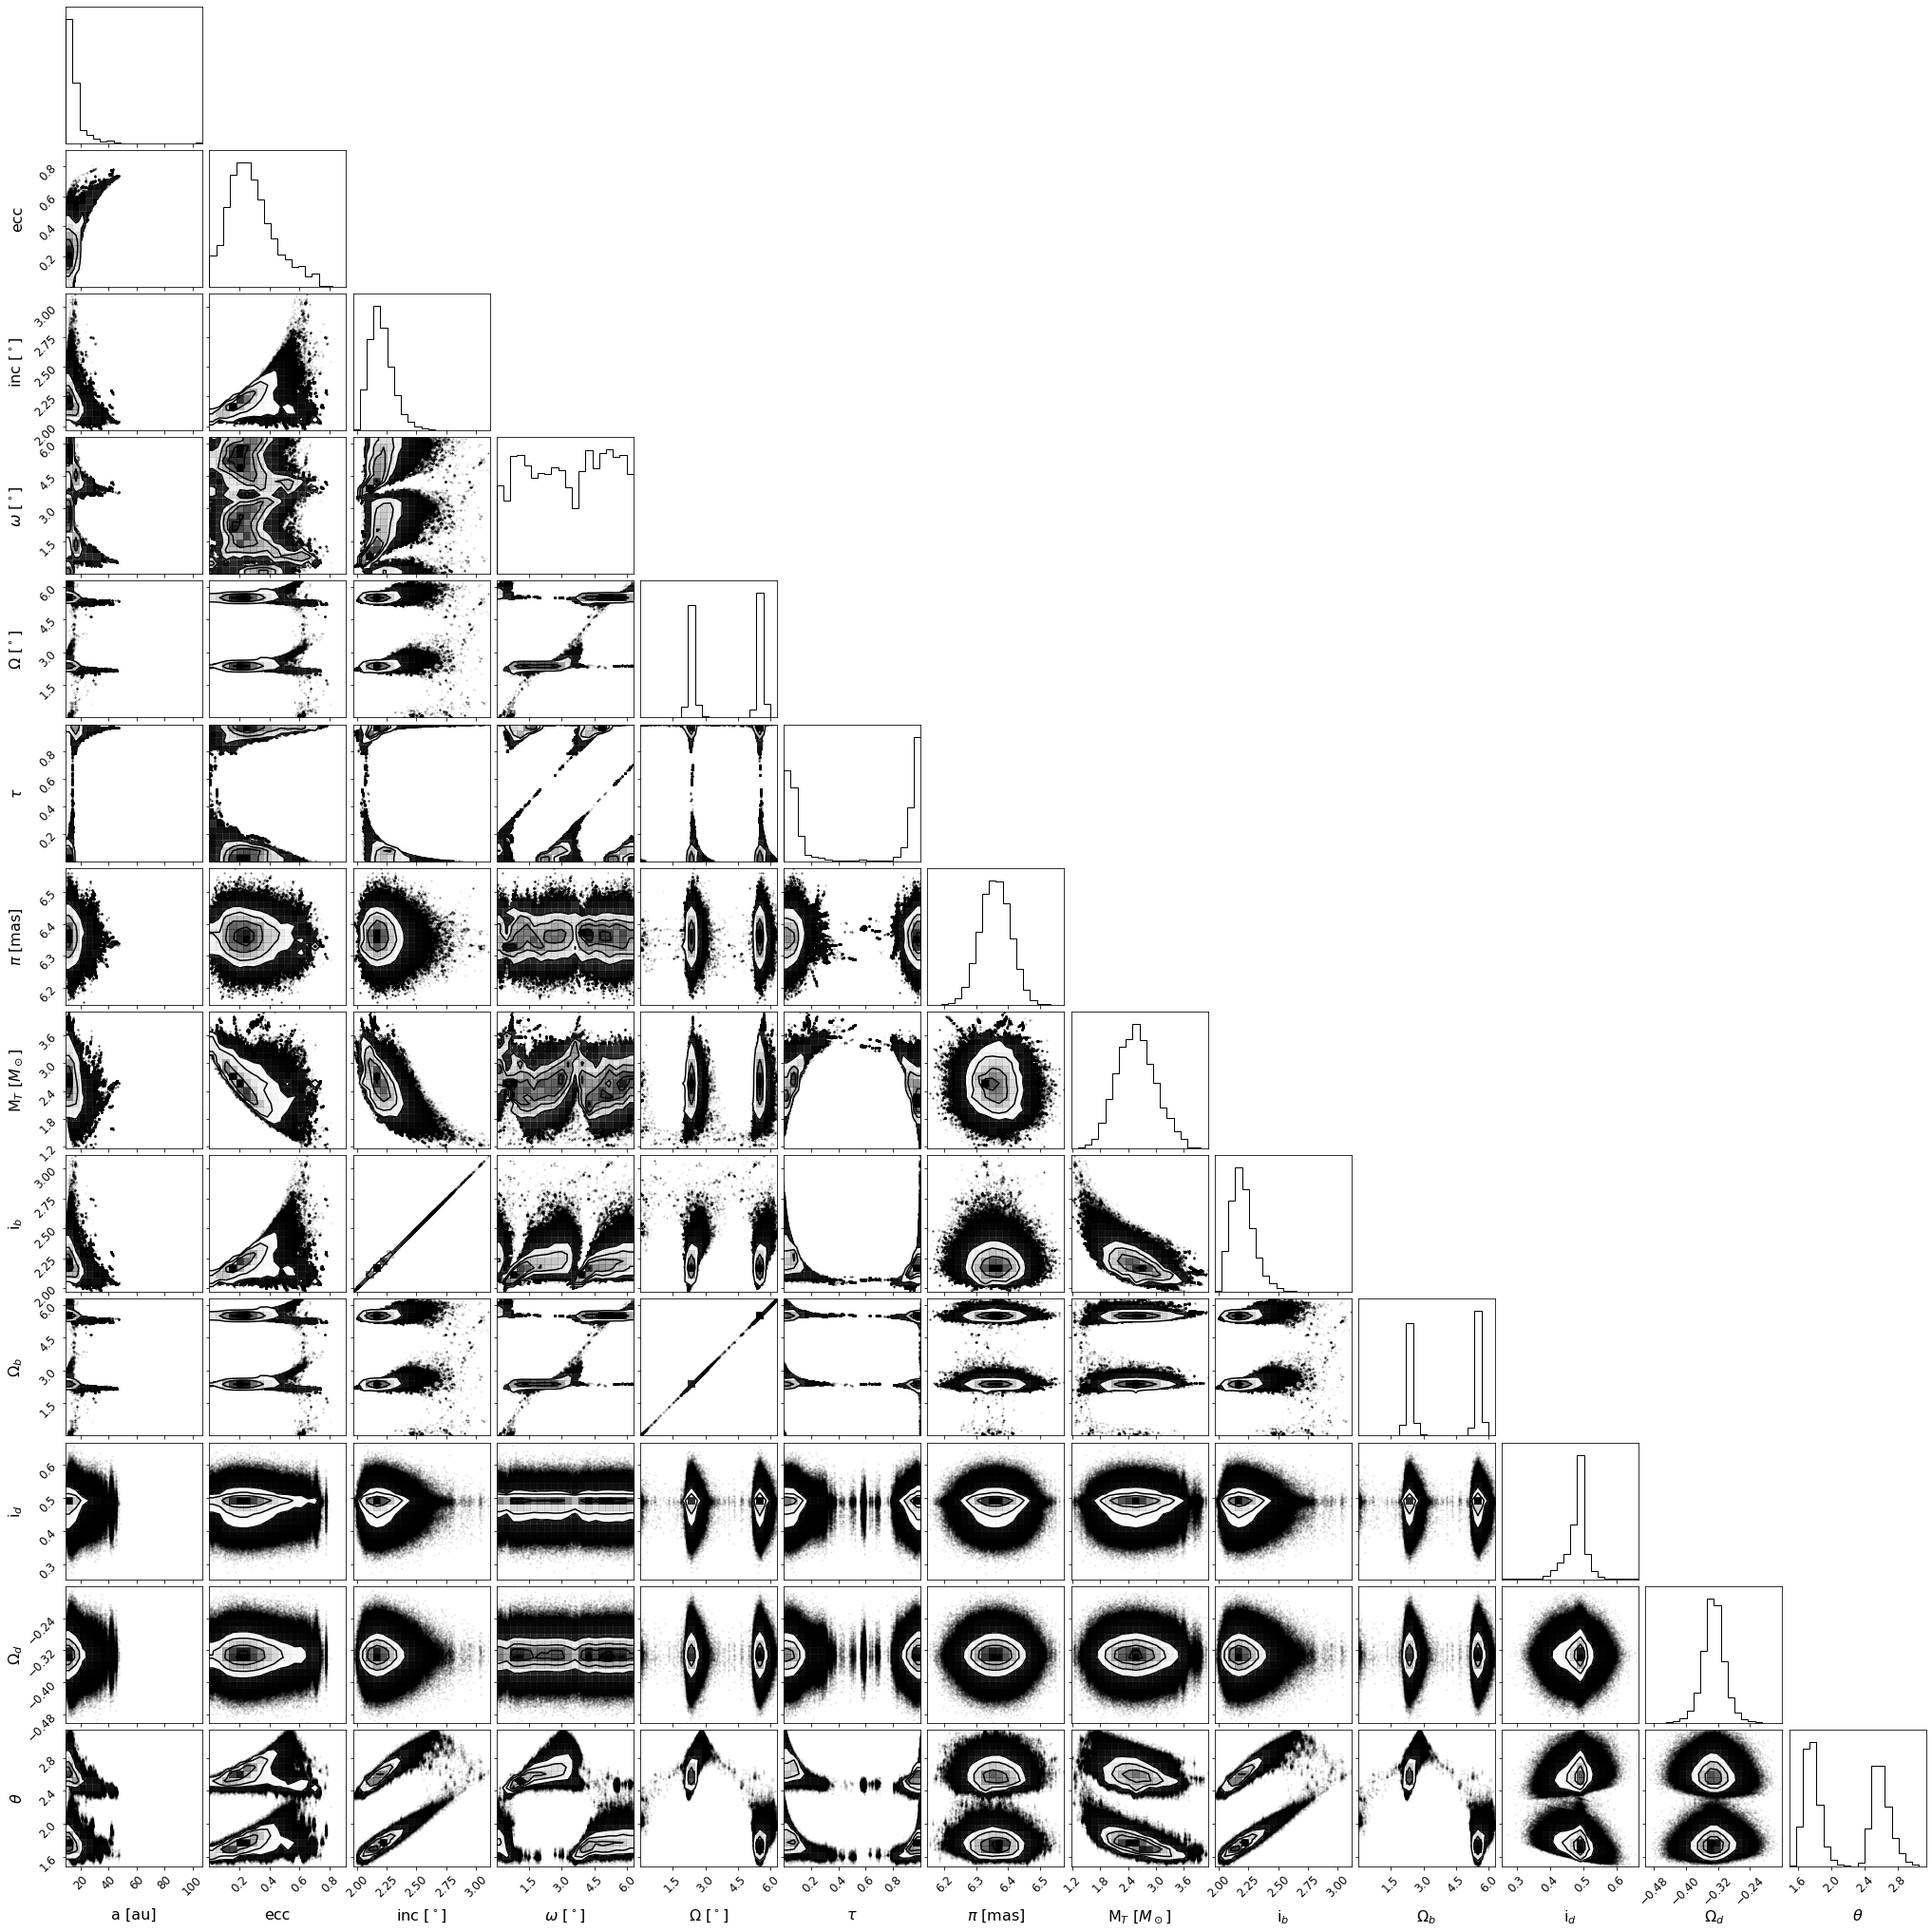

In [17]:
allcorn = corner.corner(data2, labels=['a [au]', 'ecc', r'inc [$^\circ$]', r'$\omega$ [$^\circ$]', r'$\Omega$ [$^\circ$]', r'$\tau$', r'$\pi$ [mas]', r'M$_T$ [$M_\odot$]', r'i$_b$', r'$\Omega_b$', r'i$_d$', r'$\Omega_d$', r'$\theta$'])

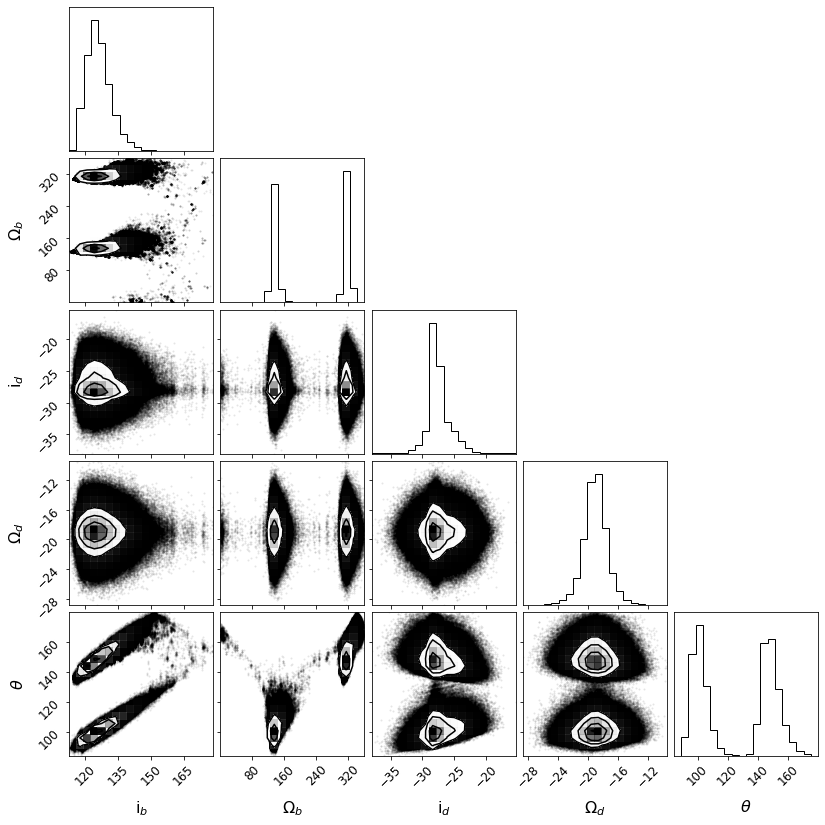

In [21]:
corn = corner.corner(diskdatadeg, labels=[r'i$_b$', r'$\Omega_b$', r'i$_d$', r'$\Omega_d$', r'$\theta$'])
plt.savefig('disk_mutual_inc_corner_almaonly.png', dpi=250)